In [329]:
import pandas as pd
import numpy as np
import seaborn as sns
from math import sin, cos, sqrt, atan2, radians

from sklearn.metrics import roc_auc_score

from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder, StandardScaler, PolynomialFeatures
from sklearn.model_selection import cross_val_score, StratifiedKFold

%matplotlib inline

In [304]:
data = pd.read_csv("CAX_TrainingData_McK.csv")
test_data = pd.read_csv("CAX_TestData_McK.csv")

In [305]:
data.head()

,offer_gk,weekday_key,hour_key,driver_gk,order_gk,driver_latitude,driver_longitude,origin_order_latitude,origin_order_longitude,distance_km,duration_min,offer_class_group,ride_type_desc,driver_response
0,1105373,5,20,6080,174182,55.818842,37.334562,55.814567,37.355010,-1.000,-1.000,Economy,private,0
1,759733,5,14,6080,358774,55.805342,37.515023,55.819329,37.466398,18.802,25.217,Standard,private,1
2,416977,6,14,6080,866260,55.813978,37.347688,55.814827,37.354074,6.747,9.800,Economy,private,0
3,889660,2,6,6080,163522,55.745922,37.421748,55.743469,37.431130,-1.000,-1.000,Economy,private,1
4,1120055,4,16,6080,506710,55.803578,37.521602,55.812559,37.527407,12.383,19.250,Economy,private,1


In [306]:
data.describe()

,offer_gk,weekday_key,hour_key,driver_gk,order_gk,driver_latitude,driver_longitude,origin_order_latitude,origin_order_longitude,distance_km,duration_min,driver_response
count,8.925570e+05,892557.000000,892557.000000,892557.000000,892557.000000,892557.000000,892557.000000,892557.000000,892557.000000,892557.000000,892557.000000,892557.000000
mean,5.654042e+05,3.162056,13.986734,3400.320598,460220.056013,55.574894,37.454412,55.739000,37.567568,13.473961,18.926885,0.740231
std,3.263001e+05,2.008709,6.626351,1981.507779,265817.226979,3.164886,2.154339,0.809843,0.563207,57.430386,44.656258,0.438508
min,0.000000e+00,0.000000,0.000000,0.000000,2.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0.000000
25%,2.825600e+05,1.000000,9.000000,1627.000000,229847.000000,55.704058,37.480870,55.703518,37.481393,-1.000000,-1.000000,0.000000
50%,5.655940e+05,3.000000,15.000000,3416.000000,460171.000000,55.755692,37.581135,55.756354,37.580863,6.923000,15.383000,1.000000
75%,8.481040e+05,5.000000,19.000000,5110.000000,690461.000000,55.802803,37.640188,55.803056,37.640674,18.199000,28.933000,1.000000
max,1.130369e+06,6.000000,23.000000,6822.000000,920378.000000,56.367198,38.987458,56.418035,38.988119,9137.747000,6752.483000,1.000000


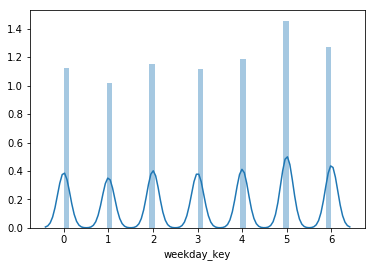

In [307]:
sns.distplot(data.weekday_key)

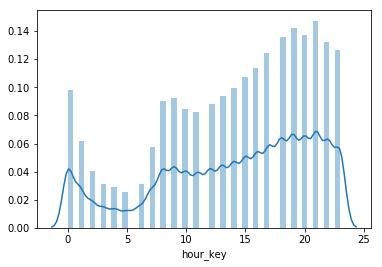

In [308]:
sns.distplot(data.hour_key)

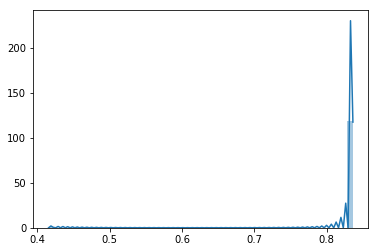

In [309]:
sns.distplot(np.log((data.driver_latitude.values+9))/5)

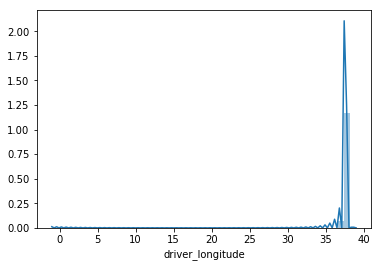

In [310]:
sns.distplot(data.driver_longitude)

In [311]:
test_data.head()

,offer_gk,weekday_key,hour_key,driver_gk,order_gk,driver_latitude,driver_longitude,origin_order_latitude,origin_order_longitude,distance_km,duration_min,offer_class_group,ride_type_desc,driver_response
0,152446,5,0,5021,648419,55.763302,37.593368,55.758230,37.613689,17.445,24.367,Premium,private,NaN
1,281031,5,7,5817,405907,55.755470,37.648689,55.741544,37.622868,-1.000,-1.000,Economy,private,NaN
2,779964,5,1,3870,894998,55.619002,37.596140,55.615923,37.607872,-1.000,-1.000,Standard,business,NaN
3,16720,5,13,5607,505054,55.620905,37.606550,55.614517,37.591161,-1.000,-1.000,Standard,private,NaN
4,492087,5,13,3786,459994,55.893228,37.673552,55.888084,37.662087,-1.000,-1.000,Standard,private,NaN


In [312]:
data.shape

(892557, 14)

In [313]:
test_data.shape

(237813, 14)

### Add feature distance between driver and offer 

In [314]:
def distance_between_two_points(lat1 = 52.2296756, lon1 = 21.0122287, lat2 = 52.406374, lon2 = 16.9251681):
    # approximate radius of earth in km
    R = 6373.0

    lat1 = radians(lat1)
    lon1 = radians(lon1)
    lat2 = radians(lat2)
    lon2 = radians(lon2)

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))

    distance = R * c

    return distance #in km

In [315]:
dist_between_driver_offer = []

In [316]:
for d_lat, d_lon, o_lat, o_lon in zip(data.driver_latitude.values,data.driver_longitude.values,data.origin_order_latitude.values,data.origin_order_longitude.values):
    dist_between_driver_offer += [distance_between_two_points(d_lat, d_lon, o_lat, o_lon)]

In [317]:
data["dist_between_driver_offer"] = dist_between_driver_offer

In [318]:
data.driver_response.value_counts()/data.shape[0]

1    0.740231
0    0.259769
Name: driver_response, dtype: float64

In [319]:
data.offer_class_group.value_counts()

Economy     424022
Standard    399867
Premium      38726
Delivery     14631
Kids          7935
VIP           4940
XL            1797
VIP+           606
Test            33
Name: offer_class_group, dtype: int64

In [320]:
test_data.offer_class_group.value_counts()

Standard    119104
Economy      98197
Premium      11080
Delivery      4733
Kids          2586
VIP           1479
XL             431
VIP+           193
Test            10
Name: offer_class_group, dtype: int64

In [321]:
le = LabelEncoder()
le.fit(["Test", "Economy", "Delivery","Standard","Kids", "XL","Premium","VIP","VIP+"])   
data.offer_class_group = le.transform(data.offer_class_group.values)

In [322]:
data.ride_type_desc.value_counts()

private      805166
business      85346
affiliate      1756
SMB             289
Name: ride_type_desc, dtype: int64

In [323]:
test_data.ride_type_desc.value_counts()

private      208983
business      28265
affiliate       466
SMB              99
Name: ride_type_desc, dtype: int64

In [324]:
le = LabelEncoder()
le.fit(["private", "affiliate","SMB", "business"])

LabelEncoder()

In [325]:
data.ride_type_desc = le.transform(data.ride_type_desc.values)

In [326]:
data.corr()

,offer_gk,weekday_key,hour_key,driver_gk,order_gk,driver_latitude,driver_longitude,origin_order_latitude,origin_order_longitude,distance_km,duration_min,offer_class_group,ride_type_desc,driver_response,dist_between_driver_offer
offer_gk,1.000000,-0.000261,0.000022,0.000566,0.000373,0.000542,0.000598,-0.000462,-0.000257,-0.000169,-0.000330,0.001015,-0.000048,-0.000485,-0.000451
weekday_key,-0.000261,1.000000,0.036483,0.001148,0.001151,0.004840,0.004596,0.001668,0.000132,-0.006715,-0.007784,0.010219,-0.000377,0.011200,-0.004999
hour_key,0.000022,0.036483,1.000000,-0.004313,0.001909,0.008520,0.006137,0.001086,-0.008854,-0.014732,-0.017460,0.000417,0.012388,0.012912,-0.006560
driver_gk,0.000566,0.001148,-0.004313,1.000000,0.000605,-0.005280,-0.003800,-0.000348,0.005843,-0.000265,-0.000222,0.004382,-0.001463,-0.000124,0.003963
order_gk,0.000373,0.001151,0.001909,0.000605,1.000000,0.002055,0.001724,0.000026,-0.001370,-0.002020,-0.001778,-0.001832,0.003777,0.000007,-0.001739
driver_latitude,0.000542,0.004840,0.008520,-0.005280,0.002055,1.000000,0.996190,0.023132,-0.029789,0.008740,0.017304,-0.045967,0.151539,-0.035317,-0.968665
driver_longitude,0.000598,0.004596,0.006137,-0.003800,0.001724,0.996190,1.000000,0.013472,-0.009625,0.011477,0.021536,-0.046578,0.152339,-0.027817,-0.967150
origin_order_latitude,-0.000462,0.001668,0.001086,-0.000348,0.000026,0.023132,0.013472,1.000000,0.939795,-0.004398,-0.006577,0.000831,0.000314,-0.012823,-0.260833
origin_order_longitude,-0.000257,0.000132,-0.008854,0.005843,-0.001370,-0.029789,-0.009625,0.939795,1.000000,0.006427,0.009837,0.000888,-0.002418,0.017114,-0.212953
distance_km,-0.000169,-0.006715,-0.014732,-0.000265,-0.002020,0.008740,0.011477,-0.004398,0.006427,1.000000,0.985412,-0.029239,0.077875,-0.055966,-0.009837


## Logistic Regression

In [172]:
log_reg = LogisticRegression(C=1,class_weight=None,random_state=777,n_jobs=-1)

In [173]:
skf = StratifiedKFold(n_splits=5,shuffle=True,random_state=777)

In [174]:
X = data.drop("driver_response",1).values
y = data["driver_response"].values

In [175]:
cv_scores=cross_val_score(log_reg,X,y, scoring="roc_auc",cv=skf,n_jobs=-1)
cv_scores

/home/konstantin/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))
/home/konstantin/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))
/home/konstantin/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))
/home/konstantin/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))
/home/konstantin/anaconda3/lib/python3.6/site-packages/sklearn/linea

array([ 0.50248511,  0.50074471,  0.59412227,  0.51235368,  0.59457325])

In [176]:
np.mean(cv_scores) 

0.54085580467080696

In [177]:
log_reg = LogisticRegression(C=1,class_weight=None,random_state=777,n_jobs=-1)
skf = StratifiedKFold(n_splits=5,shuffle=True,random_state=777)
X = data.drop(["driver_response","offer_gk"],1).values
y = data["driver_response"].values
cv_scores=cross_val_score(log_reg,X,y, scoring="roc_auc",cv=skf,n_jobs=-1)
cv_scores

/home/konstantin/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))
/home/konstantin/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))
/home/konstantin/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))
/home/konstantin/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))
/home/konstantin/anaconda3/lib/python3.6/site-packages/sklearn/linea

array([ 0.50874124,  0.50721625,  0.50996649,  0.57023808,  0.509447  ])

In [21]:
np.mean(cv_scores) #правидбно дропнул offer_gk качество лкчше

0.59076364687603489

In [22]:
log_reg = LogisticRegression(C=1,class_weight=None,random_state=777,n_jobs=-1)
skf = StratifiedKFold(n_splits=5,shuffle=True,random_state=777)
X = data.drop(["driver_response","order_gk"], 1).values 
y = data["driver_response"].values
cv_scores=cross_val_score(log_reg,X,y, scoring="roc_auc",cv=skf,n_jobs=-1)
cv_scores



/home/konstantin/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))
/home/konstantin/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))
/home/konstantin/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))
/home/konstantin/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))
/home/konstantin/anaconda3/lib/python3.6/site-packages/sklearn/linea

array([ 0.49805663,  0.49878331,  0.49908225,  0.50162474,  0.50377799])

In [23]:
np.mean(cv_scores) #order_gk не дропать

0.50026498238946404

In [24]:
log_reg = LogisticRegression(C=1,class_weight=None,random_state=777,n_jobs=-1)
skf = StratifiedKFold(n_splits=5,shuffle=True,random_state=777)
X = data.drop(["driver_response","driver_gk", "order_gk"], 1).values 
y = data["driver_response"].values
cv_scores=cross_val_score(log_reg,X,y, scoring="roc_auc",cv=skf,n_jobs=-1)
cv_scores



/home/konstantin/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))
/home/konstantin/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))
/home/konstantin/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))
/home/konstantin/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))
/home/konstantin/anaconda3/lib/python3.6/site-packages/sklearn/linea

array([ 0.5142246 ,  0.51327243,  0.51214975,  0.51563199,  0.51400341])

In [25]:
np.mean(cv_scores) # driver_gk не дропать

0.51385643588795293

In [75]:
log_reg = LogisticRegression(C=1,class_weight={0:0.75,1:0.25},random_state=777,n_jobs=-1)
skf = StratifiedKFold(n_splits=5,shuffle=True,random_state=777)
X = data.drop(["driver_response","offer_gk","order_gk","driver_gk",\
              "driver_latitude","origin_order_latitude"],1).values
y = data["driver_response"].values
cv_scores=cross_val_score(log_reg,X,y, scoring="roc_auc",cv=skf,n_jobs=-1)
cv_scores

/home/konstantin/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))
/home/konstantin/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))
/home/konstantin/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))
/home/konstantin/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))
/home/konstantin/anaconda3/lib/python3.6/site-packages/sklearn/linea

array([ 0.6460309 ,  0.64773435,  0.6424511 ,  0.64554739,  0.64825134])

In [76]:
np.mean(cv_scores)

0.64600301413204941

# XGBoost

In [254]:
xgb = XGBClassifier()

In [255]:
data.hour_key = data.hour_key.values 
X = data.drop("driver_response",1).values
y = data["driver_response"].values

In [256]:
cv_scores=cross_val_score(xgb,X,y, scoring="roc_auc",cv=skf,n_jobs=-1)
cv_scores

array([ 0.74974994,  0.75154697,  0.74937618,  0.75393102,  0.75074619])

In [257]:
np.mean(cv_scores) #0.75071952099949091

0.75107006042223023

In [182]:
xgb = XGBClassifier(nthread=-1)
skf = StratifiedKFold(n_splits=5,shuffle=True,random_state=777)
X = data.drop(["driver_response","offer_gk"],1).values
y = data["driver_response"].values
cv_scores=cross_val_score(xgb,X,y, scoring="roc_auc",cv=skf,n_jobs=-1)
cv_scores

Process ForkPoolWorker-183:
Process ForkPoolWorker-184:


KeyboardInterrupt: 

In [31]:
np.mean(cv_scores) #не дропать order_gk качество чуть лкчше

0.74441335312285595

In [27]:
xgb = XGBClassifier(nthread=-1)
skf = StratifiedKFold(n_splits=5,shuffle=True,random_state=777)
X = data.drop(["driver_response","order_gk"],1).values
y = data["driver_response"].values
cv_scores=cross_val_score(xgb,X,y, scoring="roc_auc",cv=skf,n_jobs=-1)
cv_scores

array([ 0.74291494,  0.74396427,  0.74394017,  0.74681535,  0.74436726])

In [28]:
np.mean(cv_scores)

0.74440039744150022

In [35]:
np.mean(cv_scores)

0.74161067527011892

In [36]:
xgb = XGBClassifier(nthread=-1)
skf = StratifiedKFold(n_splits=5,shuffle=True,random_state=777)
X = data.drop(["driver_response","offer_gk","order_gk","driver_gk",\
              "origin_order_latitude"],1).values
y = data["driver_response"].values
cv_scores=cross_val_score(xgb,X,y, scoring="roc_auc",cv=skf,n_jobs=-1)
cv_scores

array([ 0.74010933,  0.74063836,  0.74051927,  0.74351698,  0.74135037])

In [37]:
np.mean(cv_scores)

0.74122686076476563

In [38]:
xgb = XGBClassifier(nthread=-1)
skf = StratifiedKFold(n_splits=5,shuffle=True,random_state=777)
X = data.drop(["driver_response","offer_gk","order_gk","driver_gk",\
              "driver_latitude"],1).values
y = data["driver_response"].values
cv_scores=cross_val_score(xgb,X,y, scoring="roc_auc",cv=skf,n_jobs=-1)
cv_scores

array([ 0.73966204,  0.74130531,  0.74121669,  0.74414484,  0.74097012])

In [39]:
np.mean(cv_scores)

0.74145980119179256

In [40]:
xgb = XGBClassifier(nthread=-1)
skf = StratifiedKFold(n_splits=5,shuffle=True,random_state=777)
X = data.drop(["driver_response","offer_gk","order_gk","driver_gk",\
              "driver_latitude","origin_order_latitude"],1).values
y = data["driver_response"].values
cv_scores=cross_val_score(xgb,X,y, scoring="roc_auc",cv=skf,n_jobs=-1)
cv_scores

array([ 0.73324438,  0.73408763,  0.73355855,  0.73776923,  0.73412893])

In [41]:
np.mean(cv_scores)

0.73455774646703054

In [330]:
poly = PolynomialFeatures(degree=2, include_bias=True)

In [331]:
xgb = XGBClassifier(n_estimators=500,max_depth=6, nthread=-1,\
                   subsample=0.9, colsample_bytree=0.9, colsample_bylevel=0.9,\
                   seed=777)
skf = StratifiedKFold(n_splits=5,shuffle=True,random_state=777)
X = data.drop(["driver_response","offer_gk","order_gk","driver_gk"],1).values
X = poly.fit_transform(X)
y = data["driver_response"].values
cv_scores=cross_val_score(xgb,X,y, scoring="roc_auc",cv=skf,n_jobs=-1)
cv_scores

array([ 0.76989549,  0.7721702 ,  0.77138301,  0.77457087,  0.77194418])

In [332]:
np.mean(cv_scores)

0.77199274836756793

## The Best:

In [327]:
xgb = XGBClassifier(n_estimators=500,max_depth=6, nthread=-1,\
                   subsample=0.9, colsample_bytree=0.9, colsample_bylevel=0.9,\
                   seed=777)
skf = StratifiedKFold(n_splits=5,shuffle=True,random_state=777)
X = data.drop(["driver_response","offer_gk","order_gk","driver_gk"],1).values
#data.hour_key = data.hour_key.values // 8
y = data["driver_response"].values
cv_scores=cross_val_score(xgb,X,y, scoring="roc_auc",cv=skf,n_jobs=-1)
cv_scores

array([ 0.76867485,  0.77064106,  0.76912883,  0.77246702,  0.7713453 ])

In [328]:
np.mean(cv_scores) 

0.77045141113350968

In [65]:
le = LabelEncoder()
le.fit(["private", "affiliate", "SMB", "business"])
test_data.ride_type_desc = le.transform(test_data.ride_type_desc.values)
le.fit(["Test", "Economy", "Delivery","Standard","Kids", "XL","Premium","VIP","VIP+"])   
test_data.offer_class_group = le.transform(test_data.offer_class_group.values)

In [79]:
xgb.fit(X,y)
y_pred = xgb.predict_proba(test_data.drop(["driver_response","offer_gk","order_gk","driver_gk"],1).values)

In [84]:
take_it = []
for val in y_pred:
    take_it+=[val[1]]

In [86]:
take_it = np.array(take_it)

## Submission

In [80]:
lana_first_submit = pd.read_csv("first_dana_submit.csv")

In [94]:
submission = pd.DataFrame()
submission["offer_gk"]=lana_first_submit.offer_gk.values
submission["driver_response"]=(0.75*lana_first_submit.driver_response.values + 0.25*take_it)/2
submission.to_csv("simple_xgb_first_dana_kk_2.csv", index=False)